# L2 - Полносвязанная сеть

### 1. Многоклассовая классификация

Для каждого класса из набора $1 \dots C$ заведем свой вектор весов $w^i$ и уложим это все в матрицу $W$ по столбцам. Для простоты будем считать, что $w^i$ - столбец. Тогда наш классификатор будет выглядеть следующим образом
$$(p_1, \dots, p_{C}) = \text{softmax}(xW),$$
где $p_i$ - вероятность, что объект относится к классу $i$, при этом
$$p_i = \frac{\exp(xw_i)}{\sum_j \exp(xw_j)}.$$

Как и для задачи бинарной классификации, обучение можно свести к минимизации эмпирического риска, то есть к оптимизации следующего функционала
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_{j=0}^{\mathcal{l}}\sum_{i=0}^{C} [y_j = i] \cdot \ln(p_i(x_j W))=
\arg\min_W -\frac{1}{\mathcal{l}}\sum_{j=0}^{l} \ln(p_{y_j}(x_j W))$$
Очевидно, что сверху написано ни что иное, как максимизация логарифма правдоподобия.

Найдём градиент функции потерь по столбцу с номером k:

$$\frac{\partial Q}{\partial W^k}=-\frac{1}{\mathcal{l}}\sum_{j=0}^{l}\frac{1}{p_{y_j}(x_j W)}\cdot \frac{\partial p_{y_j}(x_j W)}{\partial W^k}$$. Распишем частную производную функции softmax класса $y_j$ (который, вообще говоря, может не совпадать с k), по двум логично вытекающим случаям:
$$\begin{cases}
               k=y_j, \frac{\partial p_{y_j}(x_j W)}{\partial W^k}=\frac{\partial}{\partial W^k} \frac{e^{x_j w^{y_j}}}{\sum_i e^{x_j w^i}}=\frac{x^{jT} e^{x_j w^{y_j}} \sum_i e^{x_j w^i}- e^{x_j w^{y_j}} x^{jT} e^{x_j w^{y_j}}}{(\sum_i e^{x_j w^i})^2}=x^{jT}p_{y_j}(x_j W)(1-p_{y_j}(x_j W))\\
               k\neq y_j, \frac{\partial p_{y_j}(x_j W)}{\partial W^k}=e^{x_j w^{y_j}} \frac{\partial}{\partial W^k}\frac{1}{\sum_i e^{x_j w^i}}=-e^{x_j w^{y_j}}\frac{-1}{(\sum_i e^{x_j w^i})^2} x^{jT} e^{x_j w^k}=-x^{jT}p_{y_j}(x_j W)p_{k}(x_j W)
            \end{cases}$$
            
Объединяя два случая с помощью символа Кронекера, получаем $\frac{\partial p_{y_j}(x_j W)}{\partial W^k}=x^{jT}p_{y_j}(x_j W)(\delta{y_j k}-p_{k}(x_j W))$. Внося это в наше произведение, получаем 
$$\frac{\partial Q}{\partial W^k}=-\frac{1}{\mathcal{l}}\sum_{j=0}^{l}x^{jT}(\delta{y_j k}-p_{k}(x_j W))=-\frac{1}{\mathcal{l}}X^{T}(\delta{y k}-p_{k}(X W))=\frac{1}{\mathcal{l}}X^T (p_{k}(X W)-\delta{y k})$$
Тогда производная по всей матрице весов равна $\frac{1}{l}X^T(p(X W)-\delta{y})$, где $y$ — матрица, в которой для каждого объекта выборки в строке стоят 9 нулей и одна единица на месте его истинного класса.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input
from keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adam, Nadam
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
nb_classes = 10

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
# add column of ones for single layer network
X_train_single, X_test_single = np.hstack([np.ones((X_train.shape[0],1)),X_train]),np.hstack([np.ones((X_test.shape[0],1)),X_test])

60000 train samples
10000 test samples


В качестве градиентного спуска возьмём самый простой вариант реализации со скоростью обучения 1 и 100 итераций.

In [3]:
def sm_single_layer_train_gd(w,X,Y, learn_rate, iter_num):
    for i in range(iter_num):
        prod=X@ w
        prod-=np.amax(prod,axis=1,keepdims=True)
        sm=np.exp(prod)/np.sum(np.exp(prod),axis=1,keepdims=True)
        g=(X.T @ (sm-Y))/X.shape[0]
        w -= learn_rate * g
    return w

In [4]:
def predict(w,X):
    prod=X @ w
    prod-=np.amax(prod,axis=1,keepdims=True)
    sm=np.exp(prod)/np.sum(np.exp(prod),axis=1,keepdims=True)
    return np.argmax(sm,axis=1)

In [5]:
def calculate_acc(w, test_features, test_labels):
    pred=predict(w,test_features)
    wrong = np.sum(pred != test_labels)
    return 1 - wrong / test_labels.shape[0]

In [6]:
w_start=np.zeros((X_train_single.shape[1],10))
w_res=sm_single_layer_train_gd(w_start,X_train_single,Y_train,1,100)
print(calculate_acc(w_res,X_test_single,y_test))

0.9096


Получили точность 90,96% на отложенной выборке. Посмотрим, получится ли её улучшить позже.

Давайте кратко каснемся темы регуляризации. Как было рассказано на семинаре, подходы есть разные. Мы же остановимся на модификации оптимизируемого функционала.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_{j=0}^{\mathcal{l}}\sum_{i=0}^{C} [y_j = i] \cdot \ln(p_i(x_j W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - пытается занулить бесполезные признаки
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - не дает параметрам быть слишком большими.

Заметим, что в случае L1-нормы градиентом является просто матрица знаков компонент матрицы, L2-нормы — матрица удвоенных компонент.

In [7]:
def sm_single_layer_train_gd_reg(w,X,Y, learn_rate,l1coeff,l2coeff, iter_num):
    for i in range(iter_num):
        prod=X@ w
        prod-=np.amax(prod,axis=1,keepdims=True)
        sm=np.exp(prod)/np.sum(np.exp(prod),axis=1,keepdims=True)
        g=(X.T @ (sm-Y))/X.shape[0]+l1coeff*np.sign(w)+l2coeff*2*w
        w -= learn_rate * g
    return w

In [8]:
reg_coeffs=np.arange(0,1,5e-2)
xgrid, ygrid = np.meshgrid(reg_coeffs, reg_coeffs)
zgrid=np.empty_like(xgrid)
for i in range(len(reg_coeffs)):
    for j in range(len(reg_coeffs)):
        w_start=np.zeros((X_train_single.shape[1],10))
        w_res=sm_single_layer_train_gd_reg(w_start,X_train_single,Y_train,1,reg_coeffs[i],reg_coeffs[j],10)
        zgrid[i][j]=calculate_acc(w_res,X_test_single,y_test)

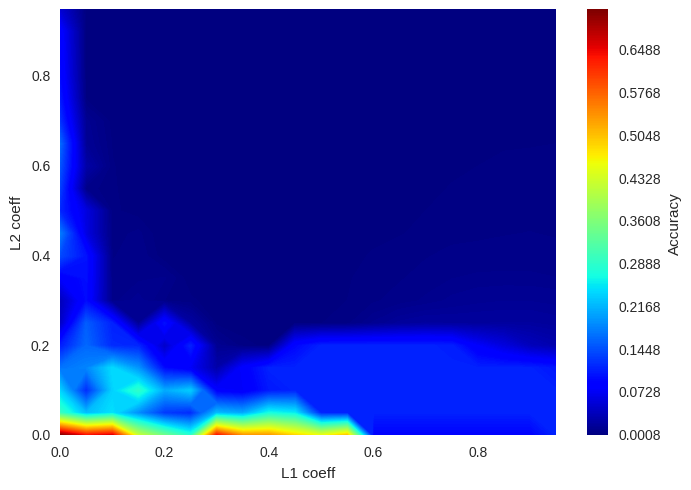

In [9]:
plt.figure()
plt.xlabel('L1 coeff')
plt.ylabel('L2 coeff')
cont=plt.contourf(xgrid, ygrid, zgrid,1000, cmap=plt.cm.jet)
cbar = plt.colorbar(cont)
cbar.ax.set_ylabel('Accuracy')
plt.show()

Как видим на графике, точность (к тому же, и Q, так как мы штрафуем некорректные классификации) с отличными от 0 коэффициентами регуляризации лишь понижается, притом значительно. Вполне возможно, что для конкретной архитектуры и данных выигрыша стратегия использования регуляризации в целом не даёт.

### 2. Полносвязные нейронные сети

Можно задаться вопросом, а что будет, если поверх модели $Wx$ применить еще одну матрицу, а затем уже $\text{softmax}$? Ответ следующий, дополнительное умножение на матрицу слева $W_2\cdot(W_1x)$ ничего не даст, в итоге это та же самая модель $Wx$, где $W=W_2 W_1$. А вот, если между матрицами добавить третий "слой", то может получиться очень интерсная штука.

Давайте рассмотрим пример на множестве бинарных функций, $x \in \{0, 1\}^{2}$. Пусть есть модель

$$y = \theta(wx + b),$$

где $\theta$ - функция [Хевисайда](https://en.wikipedia.org/wiki/Heaviside_step_function).

Рассмотрим такие $w$ и $b$, чтобы $y$ реализовала операторы *and*, *or*, *not*.

1. * and: w=(1,1),b=-1,5. 
Получаем $x_1+x_2-1,5$, и функция Хевисайда принимает значение 1, если $x_1+x_2\geq 1,5$, так как $x \in \{0, 1\}^{2}$,
то значение 1 получается только при векторе $(1,1)$.
   * or: $w=(1,1),b=-0,5$. Получаем $x_1+x_2-0,5$, и функция Хевисайда принимает значение 1, если $x_1+x_2\geq 0,5$, так как $x \in \{0, 1\}^{2}$, то значение 1 получается при векторах $(1,1)$, $(0,1)$, $(1,0)$.
   * not: $w=(-1),b=0,5$. Получаем $-x+0,5$, функция Хевисайда принимает значение 1, если $-x\geq -0,5 \Leftrightarrow x\leq 0,5$, то есть при $x=0$.
2. Существует функция XOR(x,y), которая принимает значение 1 при $x,y=(0,1)$ и $(1,0)$. Чтобы доказать линейную неразделимость множества элементов, на которых функция принимает значение 1 (а функция Хевисайда от скалярного произведения возвращает 1 в случае положительного скалярного произведения, то есть случая нахождения обеих точек по одну сторону от разделяющей прямой), составим систему неравенств:
$$\begin{array}{rcl} 0w_1+0w_2+b< 0 \Leftrightarrow b < 0 \\ 0w_1+1w_2+b \geq 0 \Leftrightarrow b \geq -w_2 \\ 1w_1+0w_2+b \geq 0 \Leftrightarrow b \geq -w_1 \\ 1w_1+1w_2+b < 0 \Leftrightarrow b < -w_1-w_2 \end{array}$$
Данная система несовместна, поэтому подходящий вектор коэффициентов привести будет невозможно.

Давайте рассмотрим случай посложнее, пусть теперь $x \in \{0, 1\}^{n}$, а
$$y = \theta(W_2 \cdot \theta(W_1x + b_1) + b_2),$$
где функция $\theta$ для вектора применяется поэлементно. Кстати, судя по размерности, $W_2$ - вектор, но для общности записан с большой буквы.

Может ли теперь $y$ реализовать произвольную булеву функцию?

Так как любая функция представима в виде ДНФ (например, построением таблицы истинности), то достаточно показать, как реализуется функция в виде ДНФ посредством $y$. Первым слоем мы можем получить конъюнкцию литералов в каждом конъюнкте (посредством and и not: $and: w=(1,\ldots,1), b=-n+0.5;$ (коэффициенты получаются по аналогичным двумерному случаю соображениям), если в конъюнкт входят не все переменные, ставим в соответствующих элементах 0 и соответственно увеличиваем b; not аналогичен двумерному случаю (применяем к отрицаемой переменной линейное преобразование). 

Затем последством or получаем дизъюнкцию всех конъюнктов $(or: w=(1,\ldots,1),b=-0,5)$, таким образом вычисляя итоговое значение функции. Так как XOR - булева функция и в ДНФ представляется как $(\overline{x}\cap y)\cup (x \cap \overline{y})$, то её также можно реализовать с помощью двух линейных слоёв и последовательного применения функций Хевисайда.

Теперь классифицируем цифры с помощью многослойной сети:

In [10]:
batch_size = 128
nb_epoch = 50

In [11]:
np.random.seed(1337)  # for reproducibility

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.131929469731
Test accuracy: 0.962


Заметим, что по сравнению с однослойной моделью качество выросло значительно — примерно на 5,2 процента.

### Зависимость от размерности первого линейного преобразования
Входной вектор имеет размер $l\cdot 785$, для корректности умножения вертикальный размер матрицы первого линейного преобразования равен 785, тогда, если её ширина $w$, то при перемножении получим матрицу $l\cdot w$. Таким образом, зависимость от размерности матрицы линейная, график зависимости точности от размерности приведён ниже.

In [12]:
acc=[]
for layer_size in range(1,12):
    
    np.random.seed(1337)  # for reproducibility

    model = Sequential()
    model.add(Dense(2**layer_size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    acc.append(score[1])

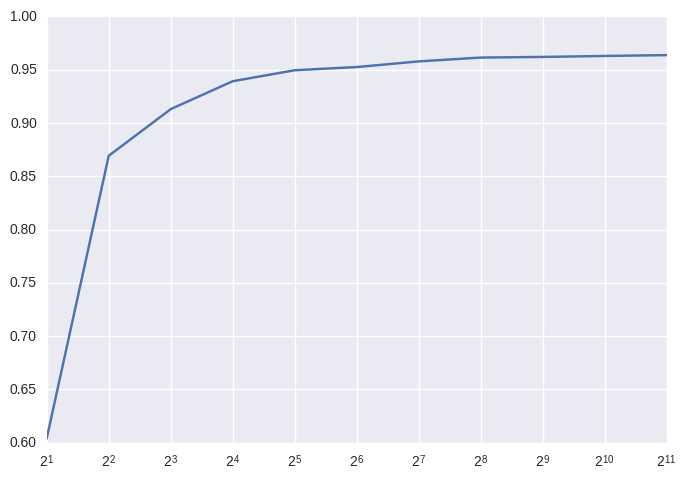

In [13]:
ax=plt.gca()
plt.plot(list((2**i for i in range (1,12))),acc)
ax.set_xscale("log",basex=2)
plt.show()

Видим, что точность сильно растёт при увеличении размера до $\approx 2^7$, однако затем она значительно не меняется, а время обучения растёт.

### Зависимость от количества слоёв

In [14]:
acc=[]
for i in range(10):
    np.random.seed(1337)  # for reproducibility

    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    for layer in range(i):
        model.add(Dense(512))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    acc.append(score[1])

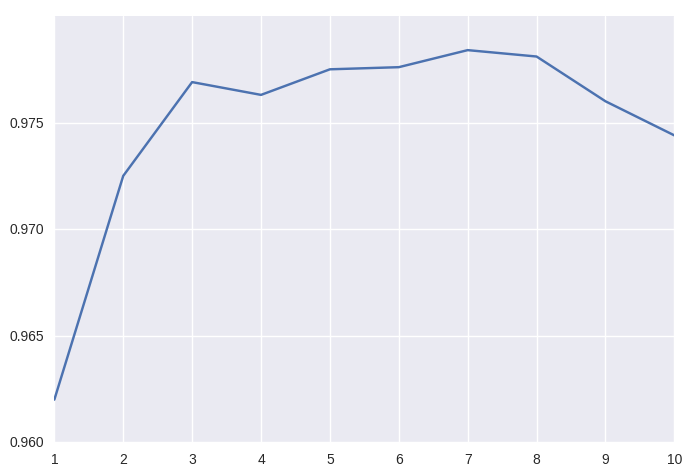

In [15]:
plt.plot(list(range(1,11)),acc)
plt.show()

Явную зависимость от числа слоём мы вывести не можем, однако при 7 слоях достигается оптимальная точность. Стоит, однако, заметить, что при ином виде оптимизации график выглядит иначе:

In [16]:
acc=[]
for i in range(10):
    np.random.seed(1337)  # for reproducibility

    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    for layer in range(i):
        model.add(Dense(512))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    acc.append(score[1])

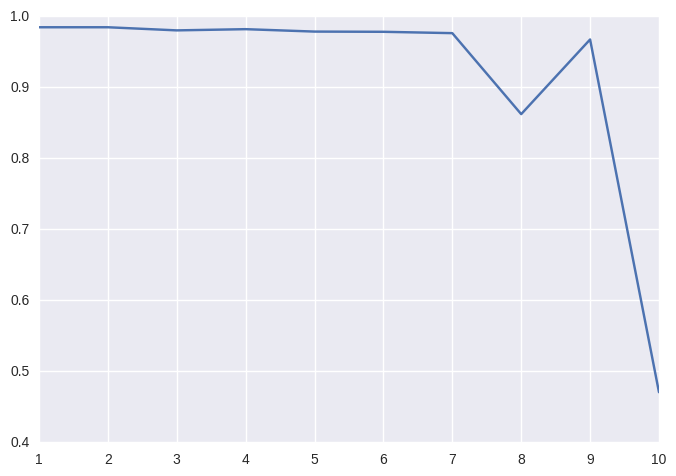

In [17]:
plt.plot(list(range(1,11)),acc)
plt.show()

Получаем, что при увеличении числа слоёв точность снижается, особенно заметно снижение при 10 слоях (оверфит?).

### Своя архитектура

In [18]:
np.random.seed(1337)  # for reproducibility

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9851


Имеем точность хоть ненамного, но большую, чем у предыдущего решения (на 2,33% больше стандартного)

### Autoencoder

In [19]:
np.random.seed(1337)  # for reproducibility
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.fit(X_train, X_train,nb_epoch=nb_epoch,batch_size=128,verbose=0,shuffle=True,validation_data=(X_test, X_test))

In [20]:
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)
encoded_test = encoder.predict(X_test)
decoded_test = decoder.predict(encoded_test)

Выведем на экран обобщения наших чисел, которые получились в результате работы автоэнкодера, а затем проверим, насколько после полученного обобщения повысится качество классификации, используя поверх модели построенную ранее.

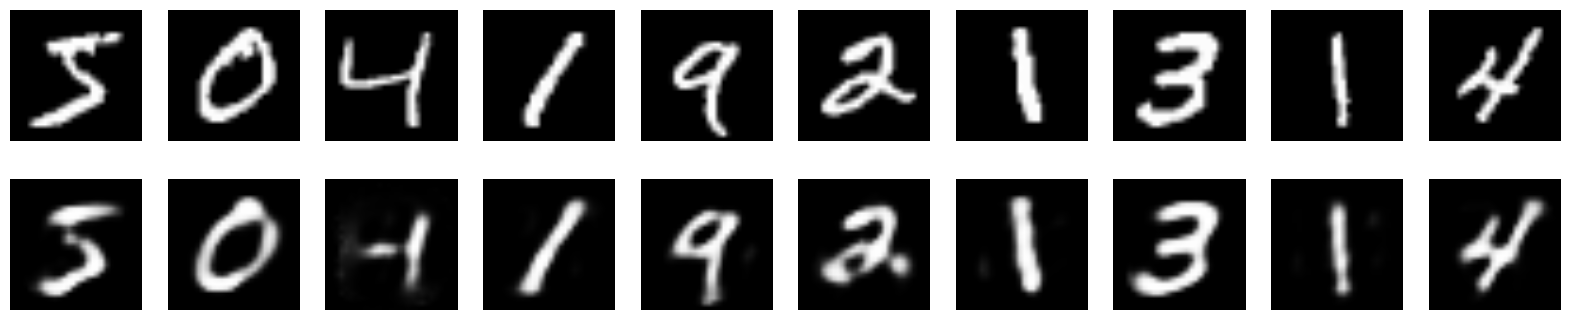

In [21]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
np.random.seed(1337)  # for reproducibility

model = Sequential()
model.add(Dense(512,input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

history = model.fit(decoded_imgs, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9754


Результат даже ухудшился. Вывод можно сделать один: одну и ту же архитектуру во всех случаях использовать не стоит.

In [34]:
layers = [
    Dense(encoding_dim, input_shape=(784,)),
    Activation('relu')
]

autoencoder = [Dense(784, input_shape=(encoding_dim,))]


model = Sequential(layers + autoencoder)
model.compile(loss='mean_squared_error',optimizer=Adadelta())

model.fit(X_train, X_train,batch_size=batch_size, nb_epoch=nb_epoch,verbose=0)
imgs = model.predict(X_train)

layers[0].trainable=False
layers[1].trainable=False
layers.append(Dense(512,input_shape=(encoding_dim,)))
layers.append(Activation('relu'))
layers.append(Dropout(0.2))
layers.append(Dense(512))
layers.append(Activation('relu'))
layers.append(Dense(512))
layers.append(Activation('tanh'))
layers.append(Dropout(0.1))
layers.append(Dense(10))
layers.append(Activation('softmax'))

model = Sequential(layers)
model.compile(loss='categorical_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])
    
model.fit(X_train, Y_train,batch_size=batch_size,nb_epoch=nb_epoch, verbose=1,validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 0.4745 - acc: 0.8530 - val_loss: 0.2436 - val_acc: 0.9234
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2035 - acc: 0.9367 - val_loss: 0.1559 - val_acc: 0.9501
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.1558 - acc: 0.9511 - val_loss: 0.1192 - val_acc: 0.9608
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.1316 - acc: 0.9588 - val_loss: 0.1015 - val_acc: 0.9676
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.1152 - acc: 0.9637 - val_loss: 0.0958 - val_acc: 0.9687
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1040 - acc: 0.9675 - val_loss: 0.0844 - val_acc: 0.9717
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.0969 - acc: 0.9699 - val_loss: 0.0849 - val_acc: 0.9729
Epoch 8/50
60000/60000 [==============================] - 1s 

Воспользовались автоэнкодером иначе: натренировав его на получение похожего на входной результата, уберём декодер и взамен добавим нужный нам классификатор. Точность, правда, всё равно ниже :(

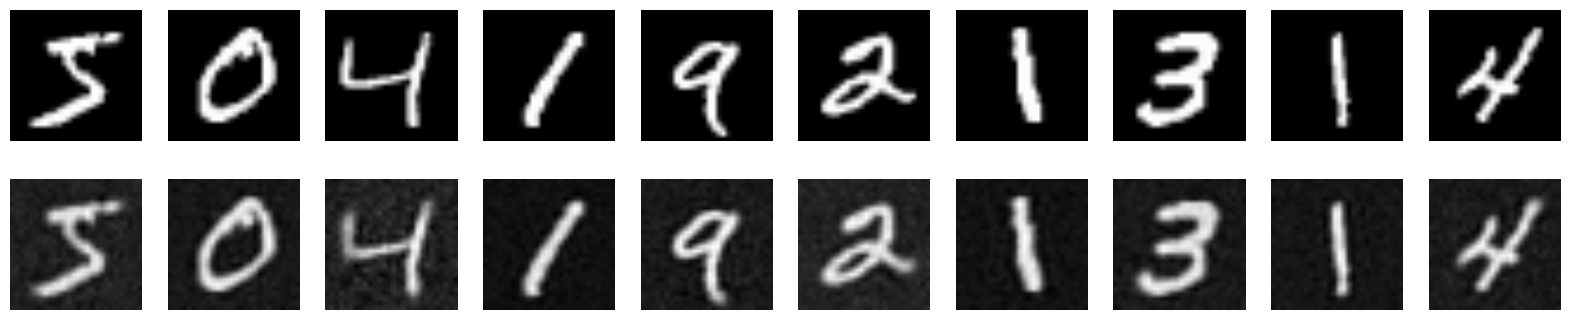

In [33]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

![test](http://cs5.pikabu.ru/images/big_size_comm/2015-06_2/14339064011920.jpg)